In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
income = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


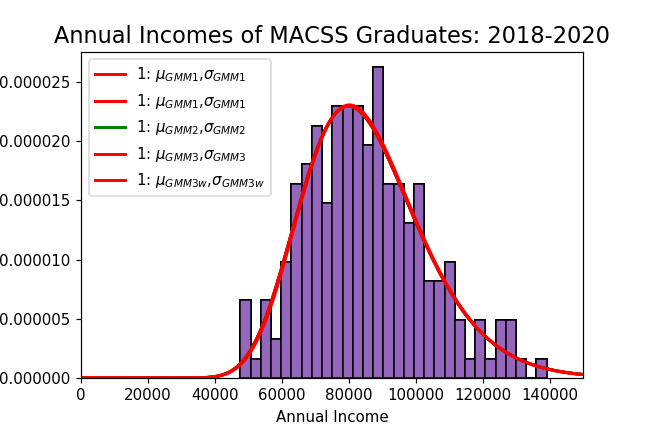

(0, 150000)

In [3]:
#1a

%matplotlib notebook
num_bins = 30
count, bins, ignored = plt.hist(income, num_bins, density=True,
                                edgecolor='k')
plt.title('Income: 2018-2020', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent')
plt.xlim([0,150000])

In [4]:
#1b

def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [5]:
def data_moments(xvals):

    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [6]:
def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

In [7]:
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [8]:
def criterion(params, *args):
   
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [9]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)


mu_GMM1= 11.33359961340108  sig_GMM1= 0.21325529509280874


In [10]:
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector=', err1)
print('GMM criterion function:',results.fun)

Mean of points = 85276.82360625811 , Standard Deviation of points = 17992.542128046523
Mean of model = 85276.82405854983 , Standard Deviation = 17992.541683009535
Error vector= [ 5.30380584e-09 -2.47345253e-08]
GMM criterion function: [[6.39927099e-16]]


In [11]:
num_bins = 30
plt.hist(income, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [12]:
#c

def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = ((mean_data - pts) ** 2) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [13]:
Err_mat =get_Err_mat2(income, mu_GMM1, sig_GMM1, 0.0, 150000.0, False)
VCV2 = (1 / income.shape[0]) * (Err_mat @ Err_mat.T)
print("VCV2:")
print(VCV2)
W_hat2 = lin.inv(VCV2)
print("W_hat2:")
print(W_hat2)

VCV2:
[[4.45167060e-02 1.68385288e+03]
 [1.68385288e+03 9.54184437e+08]]
W_hat2:
[[ 2.40701668e+01 -4.24767141e-05]
 [-4.24767141e-05  1.12297423e-09]]


In [14]:
gmm_args = (income, 0.0, 150000.0, W_hat2)
params_init = np.array([mu_GMM1, sig_GMM1])
results2 = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

print("mu_GMM1= 11.333599613401052  sig_GMM1= 0.2132552950928067")

mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(income, mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard Deviation of model =', std_model2)
print('Error vector=', err2)
print('GMM criterion function:',results2.fun)

mu_GMM2= 11.333599603618694  sig_GMM2= 0.2132552944762079
mu_GMM1= 11.333599613401052  sig_GMM1= 0.2132552950928067
Mean of points = 85276.82360625811 , Standard Deviation of points = 17992.542128046523
Mean of model = 85276.82324643618 , Standard Deviation of model = 17992.541506074045
Error vector= [-4.21945751e-09 -3.45683491e-08]
GMM criterion function: [[4.28528567e-16]]


In [15]:
num_bins = 30
plt.hist(income, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Percent of Incomes')
plt.xlim([1, 150000])

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.show()

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='g', label='1: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [16]:
#d

def data_moments3(xvals):
    
    bpct_1_dat = xvals[xvals <75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [17]:
def model_moments3(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [18]:
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):

    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [19]:
def criterion3(params, *args):

    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [20]:
W_hat1_3 = np.eye(3)
gmm_args = (income, 0.0, 150000.0, W_hat1_3)

results_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)
err3 = err_vec3(income, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)
bpct_1_dat, bpct_2_dat, bpct_3_dat=data_moments3(income)
pert1, pert2, pert3 = model_moments3(mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0)

print('Error vector=', err3)
print('GMM criterion function:',results_3.fun)
data_model_moments=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent less than 75000','Percent between 75000 and 100000','Percent more than 100000'])
data_model_moments

mu_GMM1_3= 11.33670517992345  sig_GMM1_3= 0.21151351610769806
Error vector= [ 1.13768173e-08  1.18261376e-08 -4.66305677e-08]
GMM criterion function: [[2.44369935e-15]]


,Data Moments,Model Momets
Percent less than 75000,0.3,0.3
Percent between 75000 and 100000,0.5,0.5
Percent more than 100000,0.2,0.2


In [21]:
num_bins = 30
plt.hist(income, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Income Percent')
plt.xlim([0, 150000])

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [22]:
#e

def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):

    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [23]:
Err_mat32 = get_Err_mat3(income, mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV_32 = (1 / income.shape[0]) * (Err_mat32 @ Err_mat32.T)
print("VCV:")
print(VCV_32)
W_hat_32 = lin.pinv(VCV_32)
print("W_hat")
print(W_hat_32)


VCV:
[[ 2.33333328 -0.99999998 -1.00000004]
 [-0.99999998  0.99999998 -1.00000003]
 [-1.00000004 -1.00000003  4.00000037]]
W_hat
[[ 0.25761773 -0.14958449 -0.01246537]
 [-0.14958449  0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [24]:
gmm_args = (income, 0.0, 150000.0, W_hat_32)
results_4 = opt.minimize(criterion3, params_init, args=(gmm_args),method='L-BFGS-B')
mu_GMM1_3w, sig_GMM1_3w = results_4.x
print('mu_GMM1_3w=', mu_GMM1_3w, ' sig_GMM1_3w=', sig_GMM1_3w)
err3w = err_vec3(income, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0, False).reshape(3,)

pert1, pert2, pert3 = model_moments3(mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0)

print('Error vector:', err3w)
print('GMM criterion function value:',results_4.fun)
Data_Model_Moment2=pd.DataFrame({'Data Moments':[bpct_1_dat, bpct_2_dat, bpct_3_dat],
                'Model Momets':[pert1, pert2, pert3]},
                index=['Percent less than 75000','Percent between 75000 and 100000','Percent more than 100000'])
Data_Model_Moment2

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


mu_GMM1_3w= 11.33359961340108  sig_GMM1_3w= 0.21325529509280874
Error vector: [ 0.02208416 -0.00875996 -0.01122634]
GMM criterion function value: [[0.00020989]]


,Data Moments,Model Momets
Percent less than 75000,0.3,0.306625
Percent between 75000 and 100000,0.5,0.495620
Percent more than 100000,0.2,0.197755


In [25]:
num_bins = 30
plt.hist(income, num_bins, density=True, edgecolor='k')
plt.title('Annual Incomes of MACSS Graduates: 2018-2020', fontsize=15)
plt.xlabel('Annual Income')
plt.ylabel('Income Percent')
plt.xlim([1, 150000])

plt.plot(dist_income, trunc_lognorm_pdf(dist_income, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM3w}$,$\sigma_{GMM3w}$')
plt.legend(loc='upper left')
plt.show()

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


In [26]:
#f

mu=[mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM1_3w]
sig=[sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM1_3w]
GMM_Value=[results.fun,results2.fun,results_3.fun,results_4.fun]

In [27]:
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Value":GMM_Value}
            ,index=['2 moments Identity Matrix','2 moments Weighted Matrix',
                   '3 moments Identity Matrix','3 moments Weighted Matrix']).astype(float)

,mu,sigma,GMM Value
2 moments Identity Matrix,11.333600,0.213255,6.399271e-16
2 moments Weighted Matrix,11.333600,0.213255,4.285286e-16
3 moments Identity Matrix,11.336705,0.211514,2.443699e-15
3 moments Weighted Matrix,11.333600,0.213255,2.098877e-04


In [28]:
#The second model fits the data best because it has the smallest GMM value

In [29]:
#Q2

import pandas as pd
sick = pd.read_csv('sick.txt').astype('float64')

In [30]:
def err_vec_s(df,b0,b1,b2,b3):
    
    y_h=b0+b1*sick['age']+b2*sick['children']+b3*sick['avgtemp_winter']

    err_vec = y_h - sick['sick']
    
    err_vec = np.array(err_vec)
    
    return err_vec

In [31]:
def criterion_s(params, *args):

    b0,b1,b2,b3 = params
    sick, W = args
    err = err_vec_s(sick,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val


In [32]:
params_init = np.array([1, 0, 0, 0])
W_hat = np.eye(sick.shape[0])
gmm_args = (sick, W_hat)
results_s = opt.minimize(criterion_s, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
b0, b1, b2, b3 = results_s.x

In [33]:
print("GMM Estimate of b0",b0)
print("GMM Estimate of b1",b1)
print("GMM Estimate of b2",b2)
print("GMM Estimate of b3",b3)
print('GMM criterion function:',results_s.fun)

GMM Estimate of b0 0.2516448636612042
GMM Estimate of b1 0.012933470965564249
GMM Estimate of b2 0.40050098470289774
GMM Estimate of b3 -0.009991709711286762
GMM criterion function: 0.0018212898060782808
